In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [4]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_classif,mutual_info_classif
from sklearn.feature_selection import SelectFromModel

In [7]:
from scipy.sparse import hstack

In [8]:
train = pd.read_json('data/new_modified_train.json').reset_index().drop(columns={'index'})

In [9]:
test = pd.read_json('data/new_modified_test.json').reset_index().drop(columns={'index'})

In [10]:
train_ = train.drop(columns = {'diff_rooms', 'created','rec_id','features','clean_feat', 'description','display_address','manager_id','features','photos','street_address','building_id'})

In [11]:
test_ = test.drop(columns = {'created','rec_id','features','clean_feat', 'description','display_address','manager_id','features','photos','street_address','building_id'})

In [12]:
train_['price_per_bdr'] = train_['price']*1.0 / (train_['bedrooms']+1)
train_['price_per_btr'] = train_['price']*1.0 / (train_['bathrooms']+1)
test_['price_per_bdr'] = test_['price']*1.0 / (test_['bedrooms']+1)
test_['price_per_btr'] = test_['price']*1.0 / (test_['bathrooms']+1)

# Feature Selection

## 1. Extra-Trees 

In [13]:
from sklearn.ensemble import ExtraTreesClassifier

In [14]:
def extra_tree(X, X_test, y, k):
    model = ExtraTreesClassifier() #设置ExtraTrees
    model.fit(X, y)
    temp = np.array(model.feature_importances_)
    temp_index = np.argpartition(temp, -k)[-k:]
    X_new = X.iloc[:,temp_index]
    X_test_new = X_test.iloc[:,temp_index]
    return X_new, X_test_new

## 2. KBest F-score

In [15]:
def f_score(X,X_test,y,k):
    tempindex = SelectKBest(f_classif,k=k).fit(X,y).get_support(indices = True)
    X_new = X.iloc[:,tempindex]
    X_test_new = X_test.iloc[:,tempindex]
    return X_new,X_test_new

## 3. KBest Mutual Information 

In [16]:
def MI(X,X_test,y,k):              # best
    tempindex = SelectKBest(mutual_info_classif, k=k).fit(X,y).get_support(indices=True)
    X_new = X.iloc[:,tempindex]
    X_test_new = X_test.iloc[:, tempindex]
    return X_new, X_test_new

In [17]:
X = train_.drop(columns={'interest_level'})
y = train_['interest_level']

In [18]:
X_k, test_k = extra_tree(X, test_, y, 100)

/Users/chenyizhou/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# Scaler & Label

In [19]:
Scaler = StandardScaler().fit(X_k)
X_sc = Scaler.transform(X_k)
test_sc = Scaler.transform(test_k)

In [24]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
y_label = label_encoder.transform(y)

In [25]:
dtrain = xgb.DMatrix(X_sc, y_label)
dtest = xgb.DMatrix(test_sc)

# XGBoosting

In [26]:
def modelfit(alg, dtrain, X_train, y, X_test, useCV=True, cv_fold=5, stop_r=50):
    if useCV:
        xgb_param = alg.get_xgb_params()
        xgb_train = xgb.DMatrix(X_train, y)
        num_ite = xgb_param['n_estimators']
        cv_res = xgb.cv(xgb_param, xgb_train, num_boost_round=num_ite, nfold=cv_fold, metrics='mlogloss', early_stopping_rounds=stop_r)
        alg.set_params(n_estimators=cv_res.shape[0])
        
    alg.fit(X_train, y, eval_metric='mlogloss')
    
    dtest_predictions = alg.predict(X_test)
    dtest_predprob = alg.predict_proba(X_test)
    
    return alg, dtest_predprob

In [27]:
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    'num_class': 3,
    'gama': 0.1,
    'max_depth': 12,
    'lambda': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'silent': 0,
    'eta': 0.01,
    'seed': 100,
    'nthread': 2
}
plst = params.items()

In [27]:
cv_res= xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=30, nfold=5, metrics='mlogloss',show_stdv=True)
print(cv_res)

     train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
0               1.091271            0.000031            1.092196   
1               1.083734            0.000138            1.085700   
2               1.076574            0.000261            1.079569   
3               1.069450            0.000397            1.073374   
4               1.062591            0.000371            1.067460   
5               1.055794            0.000429            1.061596   
6               1.049393            0.000617            1.055993   
7               1.042802            0.000828            1.050346   
8               1.036299            0.000976            1.044738   
9               1.029901            0.001064            1.039215   
10              1.023300            0.001084            1.033626   
11              1.017000            0.001133            1.028221   
12              1.010716            0.001077            1.022828   
13              1.004646            0.001259    

In [68]:
xgb0 = XGBClassifier(
    booster='gbtree',
    objective= 'multi:softprob',
    num_class=3,
    learning_rate =0.1,
    n_estimators=500,
    max_depth=8,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    seed=27)

### Tune max_depth and min_child_weight

In [38]:
xgb1 = XGBClassifier(
    booster='gbtree',
    objective= 'multi:softprob',
    num_class=3,
    learning_rate =0.1,
    n_estimators=140,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    seed=27)

param_test1 = {
    'max_depth':range(8,11,1),
    'min_child_weight':range(4,7,1)
}

In [39]:
gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_test1, scoring='neg_log_loss', iid=False, cv=2)
gsearch1.fit(X_sc, y)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 6}, -0.603283114321033)

In [36]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 5}, -0.5869967920717263)

### Tune gamma

In [53]:
xgb2 = XGBClassifier(
    booster='gbtree',
    objective= 'multi:softprob',
    num_class=3,
    learning_rate =0.1,
    n_estimators=120,
    max_depth=9,
    min_child_weight=6,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    seed=27)

param_test2 = {
 'gamma': [i/10.0 for i in range(0,5)]
}

In [43]:
gsearch2 = GridSearchCV(estimator = xgb2, param_grid = param_test2, scoring='neg_log_loss', n_jobs=4, iid=False, cv=3)
gsearch2.fit(X_sc, y)
gsearch2.best_params_, gsearch2.best_score_

({'gamma': 0.1}, -0.5956729354124367)

### Tune subsample and colsample 

In [60]:
xgb3 = XGBClassifier(
    booster='gbtree',
    objective= 'multi:softprob',
    num_class=3,
    learning_rate =0.1,
    n_estimators=100,
    max_depth=9,
    min_child_weight=6,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    seed=27)

param_test3 = {
    'subsample':[i/100.0 for i in range(80,95,5)],
    'colsample_bytree':[i/100.0 for i in range(65,80,5)]
}

In [61]:
gsearch3 = GridSearchCV(estimator = xgb3, param_grid = param_test3, scoring='neg_log_loss', n_jobs=4, iid=False, cv=2)
gsearch3.fit(X_sc, y)
gsearch3.best_params_, gsearch3.best_score_

({'colsample_bytree': 0.7, 'subsample': 0.9}, -0.6029574997074298)

In [56]:
gsearch3.best_params_, gsearch3.best_score_

({'colsample_bytree': 0.7, 'subsample': 0.9}, -0.6029574997074298)

In [28]:
final_xgb = XGBClassifier(
    booster='gbtree',
    objective= 'multi:softprob',
    num_class=3,
    learning_rate =0.1,
    n_estimators=800,
    max_depth=9,
    min_child_weight=6,
    gamma=0.1,
    subsample=0.9,
    colsample_bytree=0.7,
    scale_pos_weight=1,
    seed=27)

In [29]:
final_xgb, pro = modelfit(final_xgb, dtrain, X_sc, y_label, test_sc)

In [36]:
kf = KFold(n_splits=5)
for train_index, valid_index in kf.split(X_sc, y_label):
    X_train = X_sc[train_index]
    X_valid = X_sc[valid_index]
    y_train = y.iloc[train_index]
    y_valid = y.iloc[valid_index]
    final_xgb.fit(X_train, y_train)
    print(final_xgb.score(X_train, y_train), final_xgb.score(X_valid, y_valid))
# print("scores on train and valid: ", np.mean(Scores_train), np.mean(Scores_valid))

0.9014542865859859 0.744940506457846
0.9019627783992678 0.748601647513475
0.9034628292484491 0.7319231160378318
0.9037933489270823 0.7379233194345571
0.9004881521407505 0.7396521915997153


In [40]:
from sklearn.metrics import confusion_matrix

In [41]:
def cm_plot(y_valid,y_pred):
    cm = confusion_matrix(y_valid, y_pred, labels = ['high','low','medium'])
    cm = pd.DataFrame(cm,columns=['high','low','medium'],index = ['high','low','medium'])
    plt.title('Confusion Matrix',fontsize=18)
    ax = sns.heatmap(cm,annot=True,cmap='Reds', fmt='.20g', linewidths = 0)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Predicted Label',fontsize=12)
    plt.ylabel('True Label',fontsize=12)
    plt.savefig('cm.png',dpi=800)

In [37]:
y_pred = final_xgb.predict(X_valid)

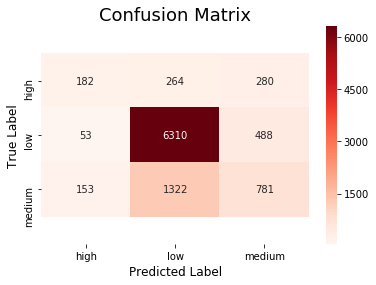

In [42]:
cm_plot(y_valid, y_pred)

In [43]:
final_final_xgb = XGBClassifier(
    booster='gbtree',
    objective= 'multi:softmax',
    num_class=3,
    learning_rate =0.05,
    n_estimators=800,
    max_depth=8,
    min_child_weight=6,
    gamma=0.1,
    subsample=0.9,
    colsample_bytree=0.7,
    scale_pos_weight=1,
    seed=27)

In [44]:
final_final_xgb, pro2 = modelfit(final_final_xgb, dtrain, X_sc, y_label, test_sc)

In [47]:
final_3_xgb = XGBClassifier(
    booster='gbtree',
    objective= 'multi:softprob',
    num_class=3,
    learning_rate =0.1,
    n_estimators=800,
    max_depth=7,
    min_child_weight=6,
    gamma=0.1,
    subsample=0.9,
    colsample_bytree=0.7,
    scale_pos_weight=1,
    seed=27)

In [48]:
final_3_xgb, pro3 = modelfit(final_3_xgb, dtrain, X_sc, y_label, test_sc)

In [ ]:
kf = KFold(n_splits=5)
for train_index, valid_index in kf.split(X_sc, y_label):
    X_train = X_sc[train_index]
    X_valid = X_sc[valid_index]
    y_train = y.iloc[train_index]
    y_valid = y.iloc[valid_index]
    final_3_xgb.fit(X_train, y_train)
    print(final_3_xgb.score(X_train, y_train), final_3_xgb.score(X_valid, y_valid))
# print("scores on train and valid: ", np.mean(Scores_train), np.mean(Scores_valid))

In [196]:
initial_xgb = XGBClassifier(
    booster='gbtree',
    objective= 'multi:softmax',
    num_class=3,
    learning_rate =0.1,
    n_estimators=100,
    max_depth=12,
    min_child_weight=1,
    gamma=0,
    seed=27)

In [197]:
initial_xgb.fit(X_sc, y_label, eval_metric='mlogloss')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, silent=None, subsample=1, verbosity=1)

In [203]:
kf = KFold(n_splits=5)
for train_index, valid_index in kf.split(X_sc, y_label):
    X_train = X_sc[train_index]
    X_valid = X_sc[valid_index]
    y_train = y.iloc[train_index]
    y_valid = y.iloc[valid_index]
    initial_xgb.fit(X_train, y_train)
    print(initial_xgb.score(X_train, y_train), initial_xgb.score(X_valid, y_valid))
# print("scores on train and valid: ", np.mean(Scores_train), np.mean(Scores_valid))

0.9625241533611308 0.7391436997864335
0.9598545713414014 0.7393470965117461
0.9588375877148377 0.7251093257398555
0.9638208074849995 0.7351774636428353
0.9555832401098342 0.7321265127631446


In [198]:
pro_init = initial_xgb.predict_proba(test_sc)

# Fusion with LR

In [118]:
X_train_leaves = final_xgb.apply(X_sc)

In [123]:
X_train_leaves.shape

(49165, 483)

In [119]:
X_test_leaves = final_xgb.apply(test_sc)

In [124]:
X_test_leaves.shape

(74659, 483)

In [120]:
X_leaves = np.concatenate((X_train_leaves, X_test_leaves), axis=0)

In [125]:
X_leaves.shape

(123824, 483)

In [129]:
xgbenc = OneHotEncoder(categories='auto')
X_trans = xgbenc.fit_transform(X_leaves)

In [150]:
lr =  LogisticRegression(penalty='l2', C=10.0, solver='sag', multi_class='multinomial', max_iter=1000)

In [136]:
train_rows = X_train_leaves.shape[0]
test_rows = X_test_leaves.shape[0]

In [138]:
X_train_ext = hstack([X_trans[:train_rows, : ], X_sc])
X_test_ext = hstack([X_trans[train_rows:, : ], test_sc])

In [151]:
lr.fit(X_train_ext, y_label)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [152]:
pro3 = lr.predict_proba(X_test_ext)

# Stacking

In [173]:
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [174]:
rf = RandomForestClassifier(n_estimators=200, max_depth=20, oob_score=True, n_jobs=4)
GNB = GaussianNB()

In [175]:
Stacking = StackingClassifier(classifiers=[GNB, final_xgb], use_probas=True, average_probas=False, meta_classifier=lr)

In [176]:
Stacking.fit(X_sc, y_label)

StackingClassifier(average_probas=False,
                   classifiers=[GaussianNB(priors=None, var_smoothing=1e-09),
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.7, gamma=0.1,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=9,
                                              min_child_weight=6, missing=None,
                                              n_estimators=161, n_jobs=1,
                                              nthread=None, num_class=3,
                                              objecti...
                   meta_classifier=LogisticRegression(C=10.0, class_weight=None,
                                                      dual=False,
                

In [177]:
pro4 = Stacking.predict_proba(test_sc)

In [31]:
def to_result_format(X,y):
    res = pd.DataFrame(y,columns=['high', 'low', 'medium'])
    temp = res['low']
    res = res.drop(columns = {'low'})
    res.insert(2,'low',temp)
    res.insert
    res.insert(0,'listing_id',X['listing_id'])
    return res

In [32]:
res = to_result_format(test,pro)

In [45]:
res2 = to_result_format(test, pro2)

In [49]:
res3 = to_result_format(test, pro3)

In [33]:
res.to_csv('submission_final.csv',index = None)

In [46]:
res2.to_csv('submission_final_final.csv',index = None)

In [50]:
res3.to_csv('submission_final_3.csv',index = None)

In [34]:
final_xgb.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 9,
 'min_child_weight': 6,
 'missing': None,
 'n_estimators': 175,
 'nthread': 1,
 'objective': 'multi:softprob',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 27,
 'subsample': 0.9,
 'verbosity': 1,
 'num_class': 3}